**Exercise 1**

In [1]:
import cv2
import numpy as np
from skimage.feature import local_binary_pattern
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt

In [18]:
def display_image(title, image,cmap):
    plt.figure(figsize=(4,4))
    plt.title(title)
    plt.imshow(image, cmap=cmap)
    plt.axis('off')
    plt.show()

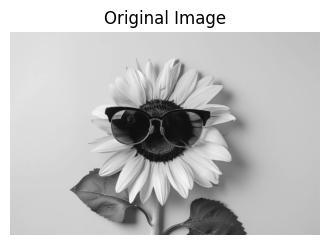

In [31]:
image = cv2.imread('image1.jpg', cv2.IMREAD_GRAYSCALE)
display_image('Original Image', image, 'gray')

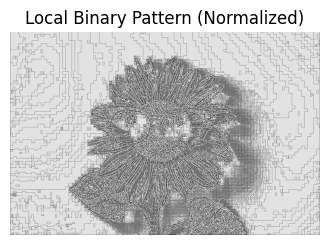

In [32]:
radius = 1
n_points = 8 * radius
method = 'uniform'
lbp = local_binary_pattern(image, n_points, radius, method)
lbp_normalized = (lbp / lbp.max() * 255).astype('uint8')
display_image('Local Binary Pattern (Normalized)', lbp_normalized, 'gray')

In [33]:
h, w = image.shape
block_size = 32
features = []
block_indices = []
for i in range(0, h, block_size):
    for j in range(0, w, block_size):
        block = lbp[i:i+block_size, j:j+block_size]
        hist, _ = np.histogram(block.ravel(), bins=np.arange(0, n_points + 3), density=True)
        features.append(hist)
        block_indices.append((i, j))
features = np.array(features)

In [34]:
n_clusters = 4
kmeans = KMeans(n_clusters=n_clusters, random_state=0)
labels = kmeans.fit_predict(features)

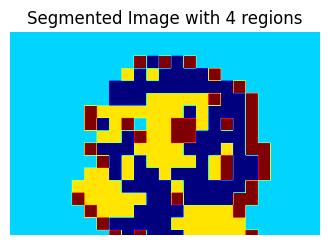

In [35]:
segmented_image = np.zeros((h, w))
for idx, (i, j) in enumerate(block_indices):
    segmented_image[i:i + block_size, j:j + block_size] = labels[idx]
display_image(f'Segmented Image with {n_clusters} regions', segmented_image, 'jet')

**Exercise 2**

In [36]:
import os
import numpy as np
from tensorflow.keras.preprocessing.image import load_img, img_to_array

In [37]:
data_dir = 'horse-or-human'
def load_images_from_directory(directory):
    images = []
    labels = []
    for label in os.listdir(directory):
        label_dir = os.path.join(directory, label)
        if os.path.isdir(label_dir):
            for file in os.listdir(label_dir):
                img_path = os.path.join(label_dir, file)
                if img_path.endswith(('png')):
                    img = load_img(img_path, target_size=(150, 150))
                    img_array = img_to_array(img) / 255.0
                    images.append(img_array)
                    labels.append(label)
    print(f"Total images: {len(images)}")
    return np.array(images), np.array(labels)

images, labels = load_images_from_directory(data_dir)

Total images: 1027


In [38]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(images, labels, test_size=0.2, random_state=42, stratify=labels)
print(f'Train set: {X_train.shape[0]} images')
print(f'Test set: {X_test.shape[0]} images')

Train set: 821 images
Test set: 206 images


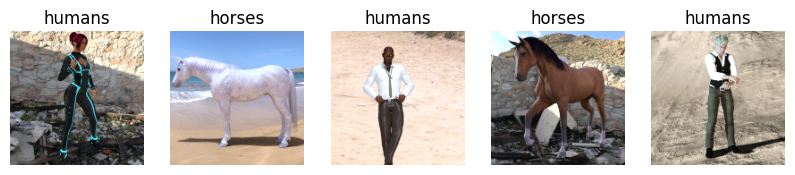

In [39]:
import matplotlib.pyplot as plt

def display_samples(images, labels, num_samples=5):
    plt.figure(figsize=(10, 10))
    for i in range(num_samples):
        plt.subplot(1, num_samples, i + 1)
        plt.imshow(images[i])
        plt.title(labels[i])
        plt.axis('off')
    plt.show()

display_samples(X_train, y_train)

In [40]:
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, Dropout, Flatten, GlobalAveragePooling2D
from tensorflow.keras import models

def build_transfer_model(base_model, neurons=128, dropout_rate=0.3):
    base_model.trainable = False
    model = models.Sequential([
        base_model,
        GlobalAveragePooling2D(),
        Dense(neurons, activation='relu'),
        Dropout(dropout_rate),
        Dense(1, activation='sigmoid')
    ])
    return model

In [41]:
from sklearn.preprocessing import LabelEncoder

label_encoder = LabelEncoder()
y_train_encoded = label_encoder.fit_transform(y_train)
y_test_encoded = label_encoder.transform(y_test)

In [42]:
from tensorflow.keras.optimizers import Adam

def compile_and_train(model, learning_rate=0.01, batch_size=32, epochs=5):
    model.compile(optimizer=Adam(learning_rate=learning_rate), loss='binary_crossentropy', metrics=['accuracy'])
    history = model.fit(X_train, y_train_encoded, validation_data=(X_test, y_test_encoded), epochs=epochs, batch_size=batch_size, verbose=1)
    return history

In [43]:
def plot_metrics(history):
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))

    ax1.plot(history.history['loss'], label='Training Loss')
    ax1.plot(history.history['val_loss'], label='Validation Loss')
    ax1.set_title('Loss')
    ax1.legend()

    ax2.plot(history.history['accuracy'], label='Training Accuracy')
    ax2.plot(history.history['val_accuracy'], label='Validation Accuracy')
    ax2.set_title('Accuracy')
    ax2.legend()
    plt.show()


Evaluating ResNet50

Epoch 1/5
26/26 ━━━━━━━━━━━━━━━━━━━━ 36s 1s/step - accuracy: 0.5428 - loss: 0.7916 - val_accuracy: 0.8010 - val_loss: 0.6220
Epoch 2/5
26/26 ━━━━━━━━━━━━━━━━━━━━ 24s 912ms/step - accuracy: 0.6528 - loss: 0.6297 - val_accuracy: 0.7718 - val_loss: 0.5599
Epoch 3/5
26/26 ━━━━━━━━━━━━━━━━━━━━ 23s 885ms/step - accuracy: 0.6948 - loss: 0.5732 - val_accuracy: 0.8010 - val_loss: 0.5450
Epoch 4/5
26/26 ━━━━━━━━━━━━━━━━━━━━ 23s 886ms/step - accuracy: 0.7184 - loss: 0.5631 - val_accuracy: 0.7816 - val_loss: 0.4920
Epoch 5/5
26/26 ━━━━━━━━━━━━━━━━━━━━ 34s 1s/step - accuracy: 0.7676 - loss: 0.4793 - val_accuracy: 0.8447 - val_loss: 0.4177


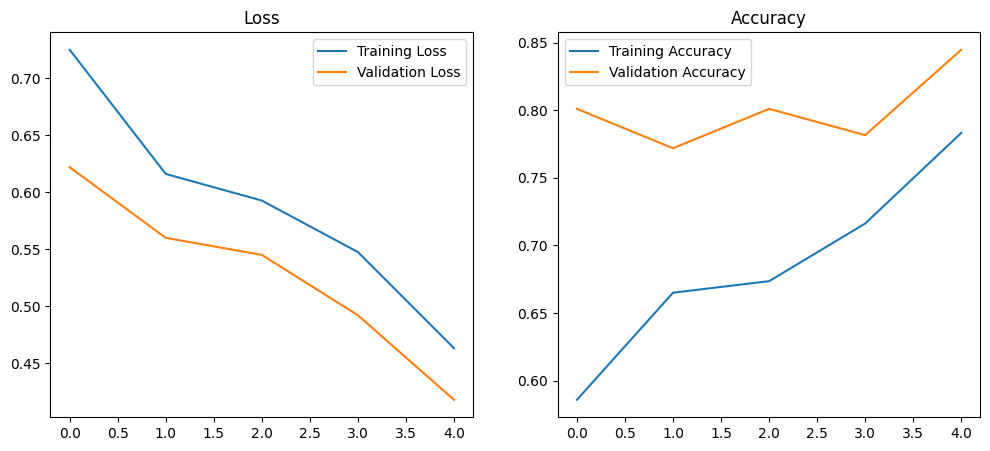

Test Loss: 0.4177, Test Accuracy: 0.8447



In [44]:
from tensorflow.keras.applications import ResNet50

experiments = [(ResNet50(weights='imagenet', include_top=False, input_shape=(150, 150, 3)), 'ResNet50')]
for base_model, model_name in experiments:
    print(f"\nEvaluating {model_name}\n")
    
    model = build_transfer_model(base_model)
    history = compile_and_train(model, 0.01, 32, 5)
    plot_metrics(history)
    test_loss, test_accuracy = model.evaluate(X_test, y_test_encoded, verbose=0)
    print(f"Test Loss: {test_loss:.4f}, Test Accuracy: {test_accuracy:.4f}\n")